In [1]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

#use gpu number 3 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#file_id=6448
file_id=23114

base_path="/home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/"
file_dry=os.path.join(base_path, "dry",str(file_id),"vocals.wav")
file_wet=os.path.join(base_path, "wet",str(file_id),"vocals.wav")

file_dry_fxnorm=os.path.join(base_path,"dry", str(file_id), "vocals_normalized.wav")
file_wet_fxnorm=os.path.join(base_path, "wet",str(file_id), "vocals_normalized.wav")

file_dry_fxnorm_dr=os.path.join(base_path, "dry", str(file_id), "vocals_normalized_dr.wav")
file_wet_fxnorm_dr=os.path.join(base_path, "wet",str(file_id),"vocals_normalized_dr.wav")

import soundfile as sf

print("Loading files:", file_dry, file_wet)
dry, sr = sf.read(file_dry)
print("Loading files:", file_dry, file_wet)
wet, sr = sf.read(file_wet)
print("files loaded")

#file_dry_fxnorm, sr=sf.read(file_dry_fxnorm_dr)
#file_wet_fxnorm, sr=sf.read(file_wet_fxnorm_dr)

dry=torch.from_numpy(dry.T).float().unsqueeze(0)
wet=torch.from_numpy(wet.T).float().unsqueeze(0)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)

dry=dry.mean(dim=1, keepdim=True)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)


start_t=15*sr
segment_length = 524288
wet_segment = wet[...,start_t:start_t + segment_length]


import pyloudnorm as pyln
meter = pyln.Meter(sr)
normaliser = lambda x: pyln.normalize.loudness(
    x, meter.integrated_loudness(x), -18.0
)

print("dry", dry.shape, dry.min(), dry.max())

dry = torch.from_numpy(normaliser(dry.numpy().T).T).float().to(device)
#wet = torch.from_numpy(normaliser(wet.numpy().T).T).float().to(device)
#dry_fxnorm = torch.from_numpy(normaliser(dry_fxnorm.numpy().T).T).float().to(device)


print("dry", dry.shape,dry.min(), dry.max())
dry_segment = dry[...,start_t:start_t + segment_length]


from IPython.display import Audio

#Audio(dry_segment[0].cpu().numpy(), rate=sr, normalize=False)
Audio(wet_segment[0].cpu().numpy(), rate=sr, normalize=True)



Using device: cuda
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/23114/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/23114/vocals.wav
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/23114/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/23114/vocals.wav
files loaded
dry torch.Size([1, 1, 7014686]) tensor(-0.7464) tensor(0.7499)


KeyboardInterrupt: 

In [7]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

from fx_model.fxnormaug_v3 import FxNormAug
randomizer=FxNormAug(sample_rate=sr, mode="train", device=device )


num_examples=512
batch_size=32

inputs_dry = dry_segment.repeat(batch_size, 1, 1).to(device)
inputs_wet = wet_segment.repeat(batch_size, 1, 1).to(device)

outputs_wet = {}

for i in range(0, num_examples, batch_size):
    res=randomizer.forward(inputs_wet, taxonomy=["92"]*batch_size)
    if res.shape[1] != 2:
        res= res.repeat(1, 2, 1)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
        outputs_wet[i*batch_size + j] = output



outputs_dry = {}

for i in range(0, num_examples, batch_size):
    res=randomizer.forward(inputs_dry, taxonomy=["92"]*batch_size)
    if res.shape[1] != 2:
        res= res.repeat(1, 2, 1)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
        outputs_dry[i*batch_size + j] = output


/home/eloi/projects/grafx/src/grafx/processors/core/convolution.py:48: UserWarning: FlashFFTConv is not available. Using native convolution instead.
  warnings.warn(


In [1]:
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from datasets.tency_mastering_vocals import TencyMastering_Vocals_Test
import omegaconf
normalize_params=omegaconf.OmegaConf.create(
    {
    "normalize_mode": "rms_dry",
    "rms_dry": -25.0
    }
)

dataset_val= TencyMastering_Vocals_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  align= False,
  align_mode= "pickle",
  base_dir= "/data5/eloi/TencyMastering_vocals/validation",
  normalize_params=normalize_params,
  num_examples= 10, #use all examples
  x_as_mono= True,
  RMS_threshold_dB= -40.0,
  seed= 42
)


from fx_model.fxnormaug_v3 import FxNormAug
randomizer=FxNormAug(sample_rate=sr, mode="train", device=device )
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch
batch_size=32
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=1)


outputs_dry = {}
outputs_wet = {}
for i,( y_wet, x_dry) in enumerate(val_loader):
    #stereo to mono
    #x= x.mean(dim=1, keepdim=True).to(device)
    x_dry= x_dry.mean(dim=1, keepdim=True).to(device)
    res=randomizer.forward(x_dry, taxonomy=["92"]*batch_size)
    if res.shape[1] != 2:
        res= res.repeat(1, 2, 1)


    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
            outputs_dry[i*batch_size + j] = output

    y_wet= y_wet.mean(dim=1, keepdim=True).to(device)
    res_wet=randomizer.forward(y_wet, taxonomy=["92"]*batch_size)
    if res_wet.shape[1] != 2:
        res_wet= res_wet.repeat(1, 2, 1)
    res_list_wet= res_wet.cpu().unbind(dim=0)
    for j, output in enumerate(res_list_wet):
            outputs_wet[i*batch_size + j] = output

    i += 1







10 num_examples


  0%|          | 0/23 [00:00<?, ?it/s]

mode dry-wet


  4%|▍         | 1/23 [00:04<01:43,  4.72s/it]

mode dry-wet


  9%|▊         | 2/23 [00:09<01:41,  4.84s/it]

mode dry-wet


 13%|█▎        | 3/23 [00:11<01:12,  3.61s/it]

mode dry-wet


 17%|█▋        | 4/23 [00:14<01:02,  3.28s/it]

mode dry-wet


 22%|██▏       | 5/23 [00:17<00:59,  3.32s/it]

mode dry-wet


 26%|██▌       | 6/23 [00:21<00:59,  3.52s/it]

mode dry-wet


 30%|███       | 7/23 [00:25<00:58,  3.63s/it]

mode dry-wet


 35%|███▍      | 8/23 [00:28<00:51,  3.40s/it]

mode dry-wet


 39%|███▉      | 9/23 [00:31<00:43,  3.14s/it]

mode dry-wet


 43%|████▎     | 10/23 [00:35<00:46,  3.61s/it]

mode dry-wet


 48%|████▊     | 11/23 [00:38<00:39,  3.30s/it]

mode dry-wet


 52%|█████▏    | 12/23 [00:41<00:35,  3.21s/it]

mode dry-wet


 57%|█████▋    | 13/23 [00:45<00:35,  3.52s/it]

mode dry-wet


 61%|██████    | 14/23 [00:48<00:29,  3.26s/it]

mode dry-wet


 65%|██████▌   | 15/23 [00:54<00:32,  4.08s/it]

mode dry-wet


 70%|██████▉   | 16/23 [00:59<00:31,  4.44s/it]

mode dry-wet


 74%|███████▍  | 17/23 [01:04<00:27,  4.64s/it]

mode dry-wet


 78%|███████▊  | 18/23 [01:08<00:22,  4.47s/it]

mode dry-wet


 83%|████████▎ | 19/23 [01:12<00:17,  4.36s/it]

mode dry-wet


 87%|████████▋ | 20/23 [01:17<00:13,  4.39s/it]

mode dry-wet


 91%|█████████▏| 21/23 [01:19<00:07,  3.86s/it]

mode dry-wet


 96%|█████████▌| 22/23 [01:23<00:03,  3.77s/it]

mode dry-wet


100%|██████████| 23/23 [01:26<00:00,  3.78s/it]


test_samples 10 num_examples 10


/home/eloi/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'sr' is not defined

In [ ]:
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.collators import collate_multitrack_paired
from fx_model.apply_effects_multitrack_utils import multitrack_batched_processing
import os
from datasets.tency_mastering_multitrack_paired import TencyMastering_Test
import omegaconf
normalize_params=omegaconf.OmegaConf.create(
    {
    "normalize_mode": "rms_dry",
    "rms_dry": -25.0
    }
)

dataset_val= TencyMastering_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  tracks= "all",
  num_tracks= 2,
  path_csv= "/data5/eloi/TencyMastering/PANNs_country_pop/val_split.csv",
  normalize_params=normalize_params,
  num_examples= -1, #use all examples
  RMS_threshold_dB= -40.0,
  seed= 42
)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

from fx_model.fxnormaug_v3_noiseless import FxNormAug
randomizer=FxNormAug(sample_rate=44100, mode="train", device=device )
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch
batch_size=32
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=1, collate_fn=lambda x: x)


outputs_dry = {}
outputs_wet = {}
for i,  data in enumerate(val_loader):
    print(i)
    data2 = data.copy()

    collated_data = collate_multitrack_paired(data2)

    x=collated_data['x'].to(device)  # x is a tensor of shape [B, N, C, L] where B is the batch size, N is the number of tracks, C is the number of channels and L is the length of the audio
    y=collated_data['y'].to(device)  # x is a tensor of shape [B, N, C, L] where B is the batch size, N is the number of tracks, C is the number of channels and L is the length of the audio
    taxonomy=collated_data['taxonomies']  # taxonomy is a list of lists of taxonomies, each list is a track, each taxonomy is a string of 2 digits
    masks=collated_data['masks'].to(device)  # masks is a tensor of shape [B, N] where B is the batch size and N is the number of tracks, it is used to mask the tracks that are not present in the batch
    paths=collated_data['paths']  # paths is a list of paths to the audio files, each path is a string



    func = lambda x, taxonomy: randomizer.forward(x, taxonomy=taxonomy) 

    x_dry_norm= multitrack_batched_processing(x.clone(), taxonomy=taxonomy, function=func, class_dependent=False, masks=masks)

    y_wet_norm= multitrack_batched_processing(y.clone(), taxonomy=taxonomy, function=func, class_dependent=False, masks=masks)


    if x_dry_norm.shape[2] != 2:
        x_dry_norm= x_dry_norm.repeat(1,1, 2, 1)

    if y_wet_norm.shape[2] != 2:
        y_wet_norm= y_wet_norm.repeat(1,1, 2, 1)




In [1]:
 
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.collators import collate_multitrack_sim
from fx_model.apply_effects_multitrack_utils import multitrack_batched_processing
import os
from datasets.tency_mastering_multitrack_simulated import TencyMastering_Test
import omegaconf

from fx_model.apply_effects_multitrack_utils import simulate_effects

normalize_params=omegaconf.OmegaConf.create(
    {
    "normalize_mode": "rms_dry",
    "rms_dry": -25.0
    }
)

dataset_val= TencyMastering_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  random_order= False,
  random_num_tracks= False,
  tracks= ["vocals","bass","drums"],
  num_tracks= -1,
  path_csv= "/data5/eloi/TencyMastering/PANNs_country_pop/val_split.csv",
  normalize_params=normalize_params,
  num_examples= -1, #use all examples
  RMS_threshold_dB= -40.0,
  seed= 42
)

from fx_model.distribution_presets.clusters_multitrack import get_distributions_Cluster0_vocals, get_distributions_Cluster1_vocals, get_distributions_Cluster0_bass, get_distributions_Cluster1_bass, get_distributions_Cluster0_drums, get_distributions_Cluster1_drums

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

from fx_model.fxnormaug_v4 import FxNormAug
randomizer=FxNormAug(sample_rate=44100, mode="train", device=device )
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

from fx_model.fx_pipeline import EffectRandomizer
effect_randomizer_C0={
  "92": EffectRandomizer(sample_rate=44100, distributions_dict=get_distributions_Cluster0_vocals(sample_rate=44100), device=device),
  "2": EffectRandomizer(sample_rate=44100, distributions_dict=get_distributions_Cluster0_bass(sample_rate=44100), device=device),
  "11": EffectRandomizer(sample_rate=44100, distributions_dict=get_distributions_Cluster0_drums(sample_rate=44100), device=device),
}

effect_randomizer_C1={
  "92": EffectRandomizer(sample_rate=44100, distributions_dict=get_distributions_Cluster1_vocals(sample_rate=44100), device=device),
  "2": EffectRandomizer(sample_rate=44100, distributions_dict=get_distributions_Cluster1_bass(sample_rate=44100), device=device),
  "11": EffectRandomizer(sample_rate=44100, distributions_dict=get_distributions_Cluster1_drums(sample_rate=44100), device=device),
}


import torch
batch_size=1
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=1, collate_fn=lambda x: x)


outputs_dry_vocals = {}
outputs_wet_vocals = {}
outputs_dry_vocals_norm = {}
outputs_wet_vocals_norm = {}

outputs_dry_bass = {}
outputs_wet_bass = {}
outputs_dry_bass_norm = {}
outputs_wet_bass_norm = {}

outputs_dry_drums = {}
outputs_wet_drums = {}
outputs_dry_drums_norm = {}
outputs_wet_drums_norm = {}


for i,  data in enumerate(val_loader):
    print(i)
    data2 = data.copy()

    collated_data = collate_multitrack_sim(data2)

    x=collated_data['x'].to(device)  # x is a tensor of shape [B, N, C, L] where B is the batch size, N is the number of tracks, C is the number of channels and L is the length of the audio
    cluster= collated_data['clusters'].to(device)  # x is a tensor of shape [B, N, C, L] where B is the batch size, N is the number of tracks, C is the number of channels and L is the length of the audio
    taxonomy=collated_data['taxonomies']  # taxonomy is a list of lists of taxonomies, each list is a track, each taxonomy is a string of 2 digits
    masks=collated_data['masks'].to(device)  # masks is a tensor of shape [B, N] where B is the batch size and N is the number of tracks, it is used to mask the tracks that are not present in the batch

    func = lambda x, taxonomy: randomizer.forward(x, taxonomy=taxonomy) 

    #x_dry_norm= multitrack_batched_processing(x.clone(), taxonomy=taxonomy, function=func, class_dependent=False, masks=masks)

    y= simulate_effects(x, cluster, taxonomy, effect_randomizer_C0, effect_randomizer_C1, masks=masks)

    #y_wet_norm= multitrack_batched_processing(y.clone(), taxonomy=taxonomy, function=func, class_dependent=False, masks=masks)

    #if x_dry_norm.shape[2] != 2:
    #    x_dry_norm= x_dry_norm.repeat(1,1, 2, 1)

    #if y_wet_norm.shape[2] != 2:
    #    y_wet_norm= y_wet_norm.repeat(1,1, 2, 1)

    outputs_dry_vocals[i] = x[0, 0, :, :]
    outputs_wet_vocals[i] = y[0, 0, :, :]
    #outputs_dry_vocals_norm[i] = x_dry_norm[0, 0, :, :]
    #outputs_wet_vocals_norm[i] = y_wet_norm[0, 0, :, :]

    outputs_dry_bass[i] = x[0, 1, :, :]
    outputs_wet_bass[i] = y[0, 1, :, :]
    #outputs_dry_bass_norm[i] = x_dry_norm[0, 1, :, :]
    #outputs_wet_bass_norm[i] = y_wet_norm[0, 1, :, :]

    outputs_dry_drums[i] = x[0, 2, :, :]
    outputs_wet_drums[i] = y[0, 2, :, :]
    #outputs_dry_drums_norm[i] = x_dry_norm[0, 2, :, :]
    #outputs_wet_drums_norm[i] = y_wet_norm[0, 2, :, :]



 

-1 num_examples


38it [02:53,  4.57s/it]


test_samples 523 num_examples -1 num_skips 0


/home/eloi/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eloi/projects/grafx/src/grafx/processors/core/convolution.py:48: UserWarning: FlashFFTConv is not available. Using native convolution instead.
  warnings.warn(


0


/home/eloi/myenv/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [4]:
import IPython.display as ipd
print(data[2][2], data[2][3])
ipd.display(ipd.Audio(data[2][0][0].cpu().numpy(), rate=44100, normalize=False))

['9220', '3200', '1241', '5220', '9120', '4100', '1110'] /data5/eloi/TencyMastering/part2/67170


In [ ]:
data[0][0][0].shape

torch.Size([4, 2, 525312])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint /data5/eloi/checkpoints/laion_clap/music_audioset_epoch_15_esc_90.14.patched.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 

/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:561: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y).permute(1,0).unsqueeze(0).to(self.device)
/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:562: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat=torch.tensor(y_hat).permute(1,0).unsqueeze(0).to(self.device)


data dict {'y': array([[-0.02549779,  0.1883294 ],
       [ 0.49634856,  0.02484811],
       [-0.1227898 ,  0.17398849],
       ...,
       [ 0.10079973, -0.00472816],
       [-0.00688584, -0.04597077],
       [-0.26677802, -0.26389915]], dtype=float32), 'y_hat': array([[ 0.23356059, -0.08300033],
       [ 0.43890107, -0.01712868],
       [ 0.01303947, -0.08378795],
       ...,
       [ 0.2504066 , -0.10853802],
       [ 0.00347324, -0.14666474],
       [-0.12216422, -0.13241981]], dtype=float32)}
data dict {'y': array([[ 41.039875 ,  -1.7836572],
       [ 14.7841   ,  37.399067 ],
       [ 28.590977 ,  -5.0912733],
       ...,
       [  9.766881 ,  -0.9173826],
       [ 14.104093 , -11.932981 ],
       [ 19.143948 , -26.746212 ]], dtype=float32), 'y_hat': array([[-37.081814 ,  -0.8475813],
       [-13.250815 ,  36.956604 ],
       [-32.84867  ,  -6.124638 ],
       ...,
       [-11.330562 ,  11.059992 ],
       [-21.715332 ,   2.2741144],
       [-11.460218 , -23.623768 ]], dtype=floa

/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


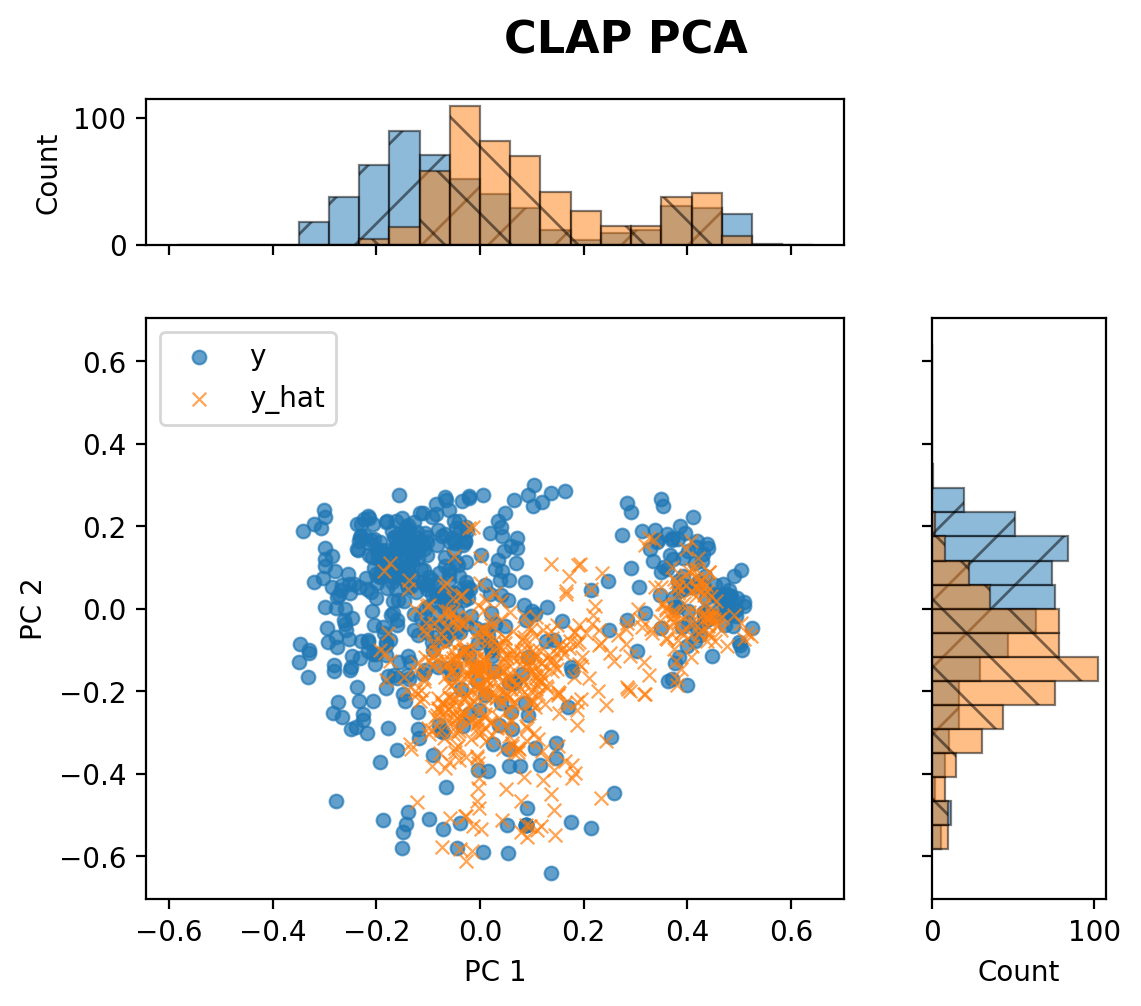

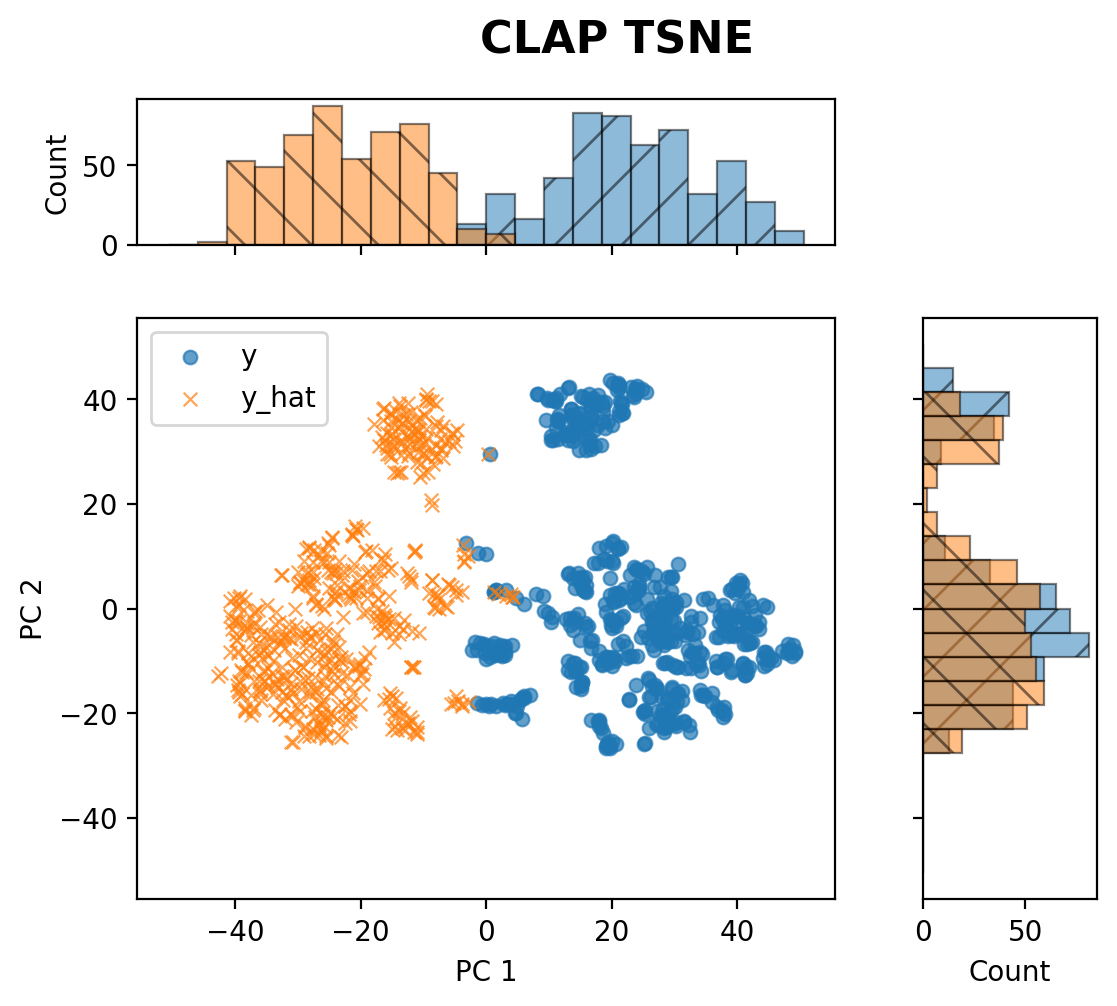

In [5]:
from evaluation.dist_metrics import KADFeatures 
import omegaconf
fx_encoder_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_default.pt",
        "config_file": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/networks/configs.yaml"
    })

fx_encoder_plusplus_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_plusplus_default.pt",
    })

AFxRep_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine", #distance metric to use for the AFxRep
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/tmp/afx-rep.ckpt"
    }
)

KAD_args = omegaconf.OmegaConf.create(
    {
  "do_PCA_figure": True, #if True, the FAD figure will be compute
  "do_TSNE_figure": True, #if True, the TSNE figure will be compute
  "PCA_fit_mode": "target",
  "kernel": "gaussian" #kernel to use for the KAD metric
    }
)

MERT_args= omegaconf.OmegaConf.create(
    {
        "layer": 8, #use the last layer of the MERT model
        "average": True, #if True, the features will be averaged over time
        "normalize": True
    }
)

CLAP_args = omegaconf.OmegaConf.create(
    {
        "ckpt_path": "/data5/eloi/checkpoints/laion_clap/music_audioset_epoch_15_esc_90.14.patched.pt",
        "distance_type": "cosine",
        "normalize": True, #if True, the features will be normalized
        "use_adaptor": False, #if True, the features will be adapted to the CLAP space
        "adaptor_checkpoint": "/data5/eloi/experiments/CLAP_regressor_sim_multitrack/MLP_CLAP_regressor-5000.pt",
        "adaptor_type": "MLP_CLAP_regressor",
        "add_noise": False, #if True, the features will be augmented with orthogonal noise
        "noise_sigma": 0.1 #sigma of the orthogonal noise to
    }
)


metric = KADFeatures(sample_rate=44100, AFxRep_args=AFxRep_args, fx_encoder_plusplus_args=fx_encoder_plusplus_args, fx_encoder_args=fx_encoder_args, type="CLAP", KAD_args=KAD_args, MERT_args=MERT_args, CLAP_args=CLAP_args)
#metric = KADFeatures(sample_rate=44100, AFxRep_args=AFxRep_args, fx_encoder_plusplus_args=fx_encoder_plusplus_args, fx_encoder_args=fx_encoder_args, type="CLAP", KAD_args=KAD_args, MERT_args=MERT_args, CLAP_args=CLAP_args)

#out_1, out_2= metric.compute(outputs_C0, outputs_C1, None)
out_1, out_2= metric.compute(outputs_dry_vocals, outputs_wet_vocals, None)

print("distance", out_1)

In [17]:

from IPython.display import Audio

Audio(outputs_dry[15].cpu().clamp(-1,1), rate=sr, normalize=False)
#Audio(x_dry[-2].cpu().clamp(-1,1), rate=sr, normalize=False)


In [6]:
import plotly.express as px
fig=px.line(outputs_dry[318].cpu().numpy()[0, 0:80000], title="Dry output 1")
fig.add_scatter(y=x_dry[-2].cpu().numpy()[0, 0:80000], name="dry original")
fig.add_scatter(y=outputs_wet[318].cpu().numpy()[0, 0:80000], name="Wet output 1")
fig.show()

In [46]:
import numpy as np
FEATURES_LOAD="/home/eloi/projects/project_mfm_automix/trainings/features/features_tency1_8instr_v4.npy"

FEATURES_LOAD_10="/home/eloi/projects/project_mfm_automix/trainings/features/features_tency1_10instr.npy"
#features_mean = np.load(FEATURES_LOAD, allow_pickle='TRUE')[()]
features_mean = np.load(FEATURES_LOAD_10, allow_pickle='TRUE')[()]

import plotly.express as px
from utils.training_utils import Gauss_smooth, Gauss_smooth_vectorized, create_music_mean_spectrum_curve, prepare_smooth_filter

target_curve_original=torch.tensor(features_mean["eq"]["vocals"]).to(torch.float32).to(device)  # Load the target EQ curve for vocals
sample_rate = 44100  # Sample rate of the audio
nfft_orig = 65536  # FFT size for the smoothing filter


nfft=4096 # FFT size hardcoded
win_length=2048  # Window length hardcoded
hop_length=1024  # Hop length hardcoded

window = torch.sqrt(torch.hann_window(win_length, device=device))
window_energy = window.pow(2).sum().sqrt()  # Energy of the window

freqs_Hz_orig=torch.fft.rfftfreq(nfft_orig, d=1.0).to(device) * sample_rate
freqs_Hz=torch.fft.rfftfreq(nfft, d=1.0).to(device) * sample_rate

smooth_filter_orig = prepare_smooth_filter(freqs_Hz_orig, Noct=3).to(device)  # Prepare the smoothing filter
smooth_filter = prepare_smooth_filter(freqs_Hz, Noct=3).to(device)  # Prepare the smoothing filter

target_curve_smooth = Gauss_smooth_vectorized(target_curve_original, freqs_Hz_orig, Noct=3, smooth_filter=smooth_filter_orig)
#normalize the target curve

target_curve_smooth = target_curve_smooth / target_curve_smooth.max()  # Normalize the target curve to the maximum value

# downsample the target curve to match the nfft
target_curve= torch.nn.functional.interpolate(
    target_curve_smooth.unsqueeze(0).unsqueeze(0),
    size=(nfft // 2 + 1,),
    mode='linear',
    align_corners=False
).squeeze(0).squeeze(0)

def EQ_normalize_fn(x):
    shape= x.shape
    x=x.view(-1, shape[-1])
    X=torch.stft(x, n_fft=nfft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)/ window_energy
    X_pow=X.abs().pow(2)
    X_mean= torch.sqrt(X_pow.mean(dim=-1, keepdim=False))  # Mean power spectrum

    ratio= target_curve / (X_mean + 1e-6)

    ratio = torch.clamp(ratio, max=10.0**(20.0/20.0))

    ratio_smooth = Gauss_smooth_vectorized(ratio, freqs_Hz, Noct=3, smooth_filter=smooth_filter)

    X= X * ratio_smooth.unsqueeze(-1)

    X_unnormalized=X* window_energy

    x_reconstructed = torch.istft(X_unnormalized, 
                     n_fft=nfft, 
                     hop_length=hop_length, 
                     win_length=win_length, 
                     window=window,
                     return_complex=False)  # Set to True if you want complex outpu

    x_reconstructed = x_reconstructed.view(shape)


    return x_reconstructed

EQ_norm_dry=EQ_normalize_fn(dry_segment)

fig=px.line(20*torch.log10(target_curve).cpu().numpy(), title="Target EQ curve for vocals", labels={"x": "Frequency (Hz)", "y": "Gain (dB)"}, log_x=True)
#fig.add_scatter(y=20*torch.log10(target_curve_smooth).cpu().numpy(), name="Smoothed curve")

shape=EQ_norm_dry.shape
x=EQ_norm_dry
x=x.view(-1, shape[-1])
X=torch.stft(x, n_fft=nfft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)/ window_energy
X_pow=X.abs().pow(2)
X_mean= torch.sqrt(X_pow.mean(dim=-1, keepdim=False))  # Mean power spectrum


fig.show()